In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import matplotlib.pyplot as plt

from MiePyV2 import *
from MieTFOld import *

2022-02-24 16:41:00.519073: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/user/ponts_m/pythonenv/lib:
2022-02-24 16:41:00.519115: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-24 16:41:03.717524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/user/ponts_m/pythonenv/lib:
2022-02-24 16:41:03.717573: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-24 16:41:03.717610: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (merlin-c-011.psi.c

# Idea for the integration function

In this section I quickly present the idea of how the integration function works

First, we define the parameters we want to use. Here I just use some random numbers within the intervals we will use

In [6]:
m = tf.constant([1.328+0.032j])
wavelength = tf.constant([450.], dtype = tf.float64)
Vtot = tf.constant(2475, dtype = tf.float64)
sigma = tf.constant(1.375, dtype = tf.float64)
rmean = tf.constant(783, dtype = tf.float64)

Then, we could theoretically make the code a bit more generic by allowing to input the upper and lower integration limits, but for our purposes we will always integrate from $50\,$nm up to $1500\,$nm and hence I hardcode this into the code, as well as the stepsize of $dx = 10$. This is done by defining the radius-array/tensor. I also need to cast the radius to a complex128 type otherwise it won't work with the rest of the code.

In [10]:
radius = tf.range(50, 15000, 10)
radius = tf.cast(radius, tf.float64)

Next, we need to define the number of functions we will calculate. This is needed for 'dimensional reasons', meaning I need to know in the code what dimensions the resulting array/tensor has so I can initiate it. For this I need the length of the radius array/tensor passed as an integer. Here, I call this number integrationsteps.

In [11]:
integrationsteps = 1495

Now I can calculate the normal (non-ensemble) phase functions by passing the radius-array together with the refractive index and the wavelength. This will create a matrix with 180 rows and as many columns as there are integrationsteps

In [12]:
print('This is the time for the function calculation: ')
TFPhaseFunctions = get_TFPhaseFunctions()
%time TFS11, TFPPF = TFPhaseFunctions(m, wavelength, radius, integrationsteps)

This is the time for the function calculation: 
CPU times: user 1min 12s, sys: 2.11 s, total: 1min 14s
Wall time: 1min 12s


To get ready for the integration we multiply the phase functions with the size-distribution. This is what will then be integrated.

In [13]:
print('This is the time for the integrand calculation: ')
radius = tf.cast(radius, tf.float64)
%time Integrand = TFS11*TFsizedistribution(radius, Vtot, sigma, rmean)

This is the time for the integrand calculation: 
CPU times: user 105 ms, sys: 8.04 ms, total: 113 ms
Wall time: 110 ms


Now we can integrate. For this, the radius-tensor needs to have the same dimensions as the phase function matrix, so we kind of stack it on top of itself 180 times, since this is the number of rows (=angles) we have. Then we perform the integration by using the trapezoidal rule and the built in tensorflow function doing just that.

In [14]:
radiusrepeat = tf.transpose(tf.repeat(radius[:,tf.newaxis], 180, axis=1))

print('This is the time for the integration: ')
%time IntegratedResult = tfp.math.trapz(Integrand, x = radiusrepeat)

This is the time for the integration: 
CPU times: user 20.1 ms, sys: 1.11 ms, total: 21.2 ms
Wall time: 9.15 ms


# Code for the integration function

The only drawback for this code as it is right now (which could maybe be improved) is that it can only calculate one parameter set at a time. So for the loss function in the end this will be a for-loop where I will iterate over the batchsize to get the integral for every set of parameters in the batch.

Currently the first integration takes $\sim 32\,$s and every subsequent integration takes $\sim 2\,$s.

In [25]:
@tf.function(experimental_relax_shapes=True)
def TFEnsembleCalculation1(m, wavelength, Vtot, sigma, rmean):
    
    m = tf.cast(m, tf.complex128)
    wavelength = tf.cast(wavelength, dtype = tf.float64)
    Vtot = tf.cast(Vtot, dtype = tf.float64)
    sigma = tf.cast(sigma, dtype = tf.float64)
    rmean = tf.cast(rmean, dtype = tf.float64)
    
    radius = tf.range(50, 15000, 10)
    radius = tf.cast(radius, tf.float64)
    
    intsteps = 1495
    
    TFS11, TFS12 = TFPhaseFunctions(m, wavelength, radius, intsteps)
    
    radius = tf.cast(radius, tf.float64)
    
    S11Integrand = TFS11*TFsizedistribution(radius, Vtot, sigma, rmean)
    S12Integrand = TFS12*TFsizedistribution(radius, Vtot, sigma, rmean)
    
    radiusrepeat = tf.transpose(tf.repeat(radius[:,tf.newaxis], 180, axis=1))
    
    S11Result = tfp.math.trapz(S11Integrand, x = radiusrepeat)
    S12Result = tfp.math.trapz(S12Integrand, x = radiusrepeat)
    
    return S11Result, -S12Result/S11Result

In [31]:
TFEnsembleCalculation = get_TFEnsembleCalculation()

# Compare the integration results to the GRASP OPEN data

loading GRASP OPEN data

In [2]:
Parameters = pd.read_csv('/data/user/ponts_m/aerosol/aerosol_data/raw_data/GRASP_LHS_rand_paremeters.csv')

PhaseFunction = pd.read_csv('/data/user/ponts_m/aerosol/aerosol_data/raw_data/ML_simulated_scat_data.csv')

In [3]:
PhaseFunction

P11_0.450_0   P11_0.450_1   P11_0.450_2   P11_0.450_3   P11_0.450_4  \
0      6.368800e-07  6.109700e-07  5.412900e-07  4.469300e-07  3.479400e-07   
1      3.997100e-07  3.686800e-07  2.938300e-07  2.093700e-07  1.381200e-07   
2      1.022200e-07  1.005900e-07  9.592600e-08  8.881100e-08  8.004000e-08   
3      9.708000e-07  9.124000e-07  7.647400e-07  5.844500e-07  4.173200e-07   
4      5.633700e-07  5.041600e-07  3.717800e-07  2.393800e-07  1.420400e-07   
...             ...           ...           ...           ...           ...   
99995  1.041800e-06  9.019600e-07  6.084900e-07  3.458400e-07  1.782700e-07   
99996  8.485600e-08  7.980900e-08  6.688300e-08  5.084500e-08  3.582100e-08   
99997  7.346600e-07  6.577500e-07  4.852300e-07  3.120300e-07  1.844100e-07   
99998  9.438100e-07  9.075800e-07  8.096000e-07  6.755000e-07  5.328700e-07   
99999  6.972400e-07  6.242900e-07  4.587900e-07  2.911400e-07  1.679700e-07   

        P11_0.450_5   P11_0.450_6   P11_0.450_7   P11_0.450_8   P11_0.450_9  \
0      2.584800e-07  1.852800e-07  1.294800e-07  8.905900e-08  6.087000e-08   
1      8.684400e-08  5.331200e-08  3.260900e-08  2.025000e-08  1.296000e-08   
2      7.043500e-08  6.071900e-08  5.143900e-08  4.295400e-08  3.545800e-08   
3      2.844200e-07  1.883600e-07  1.230800e-07  8.042200e-08  5.319300e-08   
4      8.111000e-08  4.625200e-08  2.718100e-08  1.693100e-08  1.132000e-08   
...             ...           ...           ...           ...           ...   
99995  8.875800e-08  4.533300e-08  2.491900e-08  1.526800e-08  1.026400e-08   
99996  2.387100e-08  1.533300e-08  9.664400e-09  6.081800e-09  3.889600e-09   
99997  1.044800e-07  5.880600e-08  3.387000e-08  2.051400e-08  1.321700e-08   
99998  4.018500e-07  2.927400e-07  2.080100e-07  1.454600e-07  1.009900e-07   
99999  9.213900e-08  5.009700e-08  2.803700e-08  1.673300e-08  1.078500e-08   

       ...  P12_0.630_170  P12_0.630_171  P12_0.630_172  P12_0.630_173  \
0      ...      -0.052747      -0.035190      -0.017400      -0.002096   
1      ...      -0.071542      -0.071420      -0.054486      -0.018508   
2      ...      -0.218350      -0.169500      -0.127950      -0.093591   
3      ...      -0.009081      -0.000272       0.005402       0.008272   
4      ...      -0.124020      -0.164020      -0.206960      -0.247820   
...    ...            ...            ...            ...            ...   
99995  ...      -0.229180      -0.218590      -0.191350      -0.143750   
99996  ...      -0.016720       0.000184       0.023791       0.049211   
99997  ...      -0.001231       0.001972       0.004347       0.005759   
99998  ...      -0.253780      -0.215750      -0.176840      -0.138900   
99999  ...      -0.015387      -0.033503      -0.051614      -0.064725   

       P12_0.630_174  P12_0.630_175  P12_0.630_176  P12_0.630_177  \
0           0.008360       0.012986       0.012547       0.009012   
1           0.032199       0.078827       0.094504       0.073671   
2          -0.065859      -0.043995      -0.027237      -0.014919   
3           0.008883       0.007896       0.005988       0.003786   
4          -0.275150      -0.272900      -0.230460      -0.156100   
...              ...            ...            ...            ...   
99995      -0.071882       0.022137       0.111770       0.140910   
99996       0.067518       0.070493       0.057884       0.037409   
99997       0.006170       0.005666       0.004475       0.002938   
99998      -0.103630      -0.072444      -0.046379      -0.026005   
99999      -0.066719      -0.054157      -0.032299      -0.013057   

       P12_0.630_178  P12_0.630_179  
0           0.004633       0.001252  
1           0.038134       0.010142  
2          -0.006503      -0.001607  
3           0.001817       0.000475  
4          -0.076788      -0.020044  
...              ...            ...  
99995       0.092563       0.027021  
99996       0.017834       0.004599  
99997       0.001452       0.000386  
99998      -

In [8]:
location = 340

In [9]:
Vtot = Parameters['V_tot']
Rmedian = Parameters['R_median']
GSD = Parameters['GSD']
n450 = Parameters['n_450nm']
n532 = Parameters['n_532nm']
n630 = Parameters['n_630nm']
k450 = Parameters['k_450nm']
k532 = Parameters['k_532nm']
k630 = Parameters['k_630nm']

Vtotarray = Vtot.to_numpy()
Rmedianarray = Rmedian.to_numpy()
GSDarray = GSD.to_numpy()
n450array = n450.to_numpy()
n532array = n532.to_numpy()
n630array = n630.to_numpy()
k450array = k450.to_numpy()
k532array = k532.to_numpy()
k630array = k630.to_numpy()

PhaseFunction1 = PhaseFunction.loc[location,:].to_numpy()
P11_450 = PhaseFunction1[0:180]
P11_532 = PhaseFunction1[180:360]
P11_630 = PhaseFunction1[360:540]
P12_450 = PhaseFunction1[540:720]
P12_532 = PhaseFunction1[720:900]
P12_630 = PhaseFunction1[900:1080]

Now we compare two of the GRASP OPEN parameter sets to the TensorFlow library integration. I took the first and second entry. Both have a relative error of around 2% and a std. of also around 2%, which is not perfect but also not too bad.

The first integration takes around 32 seconds, all the subsequent integrations (if you want to try out other parameters) take approximately 2-5 seconds

#### location zero in the GRASP OPEN data

In [20]:
location = 0

PhaseFunction1 = PhaseFunction.loc[location,:].to_numpy()
P11_450 = PhaseFunction1[0:180]

calculate the integral

In [10]:
m = tf.constant([n532array[location]+k532array[location]*1j], dtype=tf.complex128)
Vtot = tf.constant(Vtotarray[location], dtype=tf.float64)
sigma = tf.constant(GSDarray[location], dtype=tf.float64)
rmean = tf.constant(Rmedian[location]*1000, dtype=tf.float64) #*1000 to get from um to nm

wavelength = tf.constant([532.], dtype = tf.float64)
TFEnsembleCalculation = get_TFEnsembleCalculation()
%time S11, PPF = TFEnsembleCalculation(m, wavelength, Vtot, sigma, rmean)

Ensemble = get_TFEnsembleP11()
%time S112 = Ensemble(m, Vtot, sigma, rmean)

CPU times: user 1min 10s, sys: 893 ms, total: 1min 11s
Wall time: 1min 9s
CPU times: user 3.81 s, sys: 225 ms, total: 4.04 s
Wall time: 2.81 s


compare the result by calculating the relative error and looking at the mean $\pm$ standard deviation of the result

In [11]:
mean = np.mean((S11/max(S11)-P11_532/max(P11_532))/(P11_532/max(P11_532)))
std = np.std((S11/max(S11)-P11_532/max(P11_532))/(P11_532/max(P11_532)))

print('The mean and standard deviation for TFNew are: ', mean, ' +- ', std)

mean = np.mean((S112/max(S112)-P11_532/max(P11_532))/(P11_532/max(P11_532)))
std = np.std((S112/max(S112)-P11_532/max(P11_532))/(P11_532/max(P11_532)))

print('The mean and standard deviation for OneForAll are: ', mean, ' +- ', std)

mean = np.mean((S112/max(S112)-S11/max(S11))/(S11/max(S11)))
std = np.std((S112/max(S112)-S11/max(S11))/(S11/max(S11)))

print('The mean and standard deviation for TFNew are: ', mean, ' +- ', std)

The mean and standard deviation for TFNew are:  0.033058601767057494  +-  0.02406770565477887
The mean and standard deviation for OneForAll are:  0.03305868242747993  +-  0.02406770362925506
The mean and standard deviation for TFNew are:  7.817934098932202e-08  +-  7.219421050286856e-08


In [191]:
mean = np.mean((PPF/max(PPF)-P12_532/max(P12_532))/(PPF/max(PPF)))
std = np.std((PPF/max(PPF)-P12_532/max(P12_532))/(PPF/max(PPF)))

print('The mean and standard deviation are: ', mean, ' +- ', std)

The mean and standard deviation are:  -0.3998504101833882  +-  6.0989722619162805


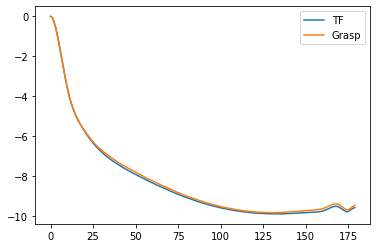

In [9]:
x = np.arange(180)
plt.figure()
plt.plot(x, np.log(S11/max(S11)), label='TF')
plt.plot(x,np.log(P11_532/max(P11_532)), label='Grasp')
plt.legend()
plt.show()

In [213]:
K5 = PPF

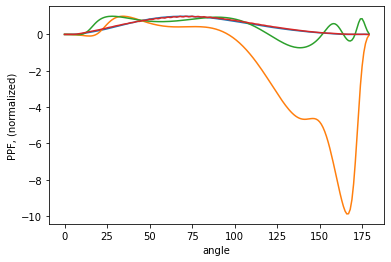

In [215]:
plt.figure()
plt.plot(x, K1/max(K1))
plt.plot(x, K2/max(K2))
plt.plot(x, K3/max(K3))
plt.plot(x, K4/max(K4))
#plt.plot(x, K5/max(K5))
plt.xlabel('angle')
plt.ylabel('PPF, (normalized)')
plt.savefig('PPF.svg')
plt.show()

#### location one in GRASP OPEN data

In [144]:
location = 1

PhaseFunction1 = PhaseFunction.loc[location,:].to_numpy()
P11_450 = PhaseFunction1[0:180]

calculate the integral

In [147]:
m = tf.constant([1.335245+0.096492j], dtype=tf.complex128)
Vtot = tf.constant([1199.644483], dtype=tf.float64)
sigma = tf.constant([1.444422], dtype=tf.float64)
rmean = tf.constant([1704.575], dtype=tf.float64)

wavelength = tf.constant([450.], dtype = tf.complex128)

%time S11, PPF = TFEnsembleCalculation(m, wavelength, Vtot, sigma, rmean)

CPU times: user 3.56 s, sys: 1.65 s, total: 5.21 s
Wall time: 2.66 s


compare the result by calculating the relative error and looking at the mean $\pm$ standard deviation of the result

In [44]:
mean = np.mean((S11/max(S11)-P11_450/max(P11_450))/(P11_450/max(P11_450)))
std = np.std((S11/max(S11)-P11_450/max(P11_450))/(P11_450/max(P11_450)))

print('The mean and standard deviation are: ', mean, ' +- ', std)

The mean and standard deviation are:  -0.025325485165349108  +-  0.015090645018546798


### Other

For location 40 of the GRASP OPEN data the phase function at 450$\,$nm has been compared to the tensorflow library and these are the relative errors corresponding to different step sizes while integrating

- $dx = 0.5: \quad -0.0092864151 \pm 0.015098053$
- $dx = 1: \quad -0.0092864193 \pm 0.015098055$
- $dx = 2: \quad -0.0092864360 \pm 0.0150980665$
- $dx = 5: \quad -0.009286550 \pm 0.015098140$
- $dx = 10: \quad -0.009286922 \pm 0.01509838$
- $dx = 23: \quad -0.009288916 \pm 0.0150994$

The other locations are expected to give similar results. Certainly the errors will be somewhat different, but in the same order of magnitude. Additionally, even if the errors get worse, the 'hierarchy' will still be the same, so the $dx=0.5$ integration will still give the best results out of these $dx$ steps.

Given that runtime is also an important factor to consider, either the $dx = 5$ or the $dx = 10$ case seem a good value to use for integration since the errors w.r.t. the smaller $dx$ steps are negligibly small.

# Compare the integration results to the Numpy code

I can still make this but I don't think it is necessary since I directly compare it to the GRASP OPEN data, which is more important anyway 

In [18]:
S11

<tf.Tensor: shape=(180,), dtype=float64, numpy=
array([0.01249225, 0.01193208, 0.0104484 , 0.00853106, 0.00672304,
       0.00538558, 0.00459614, 0.00420513, 0.00398518, 0.003768  ,
       0.0035008 , 0.00321957, 0.00298411, 0.0028243 , 0.0027225 ,
       0.00262821, 0.00248801, 0.00227446, 0.00200229, 0.0017252 ,
       0.00151225, 0.00141285, 0.0014287 , 0.00151113, 0.00158794,
       0.00160407, 0.00154971, 0.00145784, 0.00137532, 0.00133012,
       0.00131774, 0.00131268, 0.00129187, 0.00125062, 0.00120151,
       0.00116114, 0.00113735, 0.00112571, 0.00111507, 0.00109601,
       0.00106588, 0.0010289 , 0.00099289, 0.00096541, 0.00095051,
       0.00094668, 0.00094669, 0.00094047, 0.00092047, 0.00088673,
       0.00084788, 0.00081637, 0.00080034, 0.00079767, 0.00079654,
       0.00078308, 0.00075095, 0.00070657, 0.00066591, 0.00064482,
       0.00064914, 0.00067095, 0.00069319, 0.00069946, 0.00068305,
       0.00065001, 0.00061501, 0.00059258, 0.00058884, 0.00059825,
       0.00060